**Chapter 17 – Autoencoders and GANs**

_This notebook contains all the sample code in chapter 17._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

A couple utility functions to plot grayscale 28x28 image:

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

# PCA with a linear Autoencoder

Build 3D dataset:

In [3]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

Now let's build the Autoencoder...

In [4]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1.5))

In [5]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
2/2 [==============================] - 5s 17ms/step - loss: 0.4385
Epoch 2/20
2/2 [==============================] - 0s 9ms/step - loss: 0.2388
Epoch 3/20
2/2 [==============================] - 0s 9ms/step - loss: 0.5848
Epoch 4/20
2/2 [==============================] - 0s 7ms/step - loss: 0.4423
Epoch 5/20
2/2 [==============================] - 0s 7ms/step - loss: 0.1727
Epoch 6/20
2/2 [==============================] - 0s 8ms/step - loss: 0.0798
Epoch 7/20
2/2 [==============================] - 0s 7ms/step - loss: 0.0854
Epoch 8/20
2/2 [==============================] - 0s 8ms/step - loss: 0.0643
Epoch 9/20
2/2 [==============================] - 0s 8ms/step - loss: 0.0555
Epoch 10/20
2/2 [==============================] - 0s 9ms/step - loss: 0.0517
Epoch 11/20
2/2 [==============================] - 0s 8ms/step - loss: 0.0503
Epoch 12/20
2/2 [==============================] - 0s 7ms/step - loss: 0.0507
Epoch 13/20
2/2 [==============================] - 0s 8ms/step - loss: 0

In [6]:
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 6ms/step


Saving figure linear_autoencoder_pca_plot


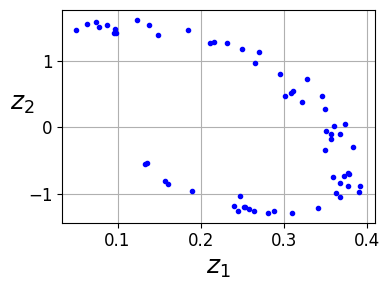

In [7]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

# Stacked Autoencoders

Let's use MNIST:

In [8]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4422102/4422102 [==============================] - 1s 0us/step


## Train all layers at once

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [9]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [10]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3382 - rounded_accuracy: 0.8865 - val_loss: 0.3212 - val_rounded_accuracy: 0.8914
Epoch 2/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3050 - rounded_accuracy: 0.9156 - val_loss: 0.3029 - val_rounded_accuracy: 0.9212
Epoch 3/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2976 - rounded_accuracy: 0.9222 - val_loss: 0.2965 - val_rounded_accuracy: 0.9231
Epoch 4/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2932 - rounded_accuracy: 0.9263 - val_loss: 0.2929 - val_rounded_accuracy: 0.9291
Epoch 5/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2904 - rounded_accuracy: 0.9290 - val_loss: 0.2907 - val_rounded_accuracy: 0.9295
Epoch 6/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2883 - rounded_accuracy: 0.9309 - val_loss: 0.2891 - val_rounded_accuracy: 0.9328
Epoch 7/20
1719/1719 [==================

This function processes a few test images through the autoencoder and displays the original images and their reconstructions:

In [11]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

1/1 [==============================] - 0s 104ms/step
Saving figure reconstruction_plot


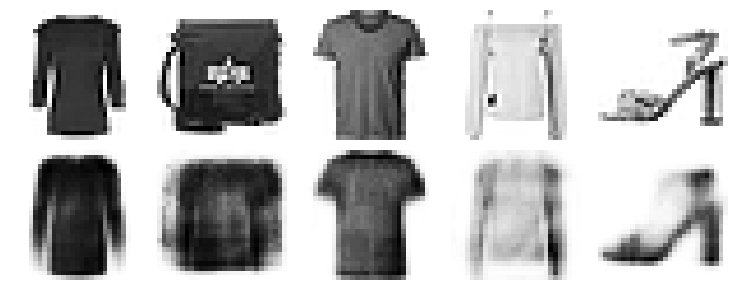

In [12]:
show_reconstructions(stacked_ae)
save_fig("reconstruction_plot")

# Visualizing Fashion MNIST

In [13]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

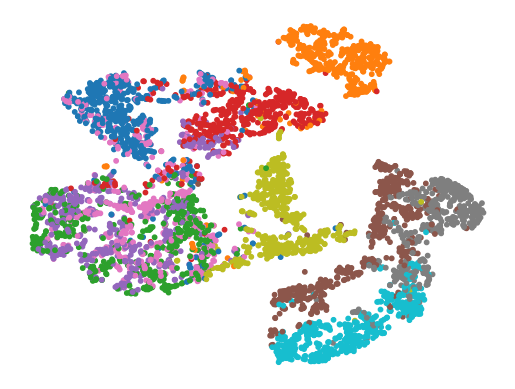

In [14]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

Let's make this diagram a bit prettier:

Saving figure fashion_mnist_visualization_plot


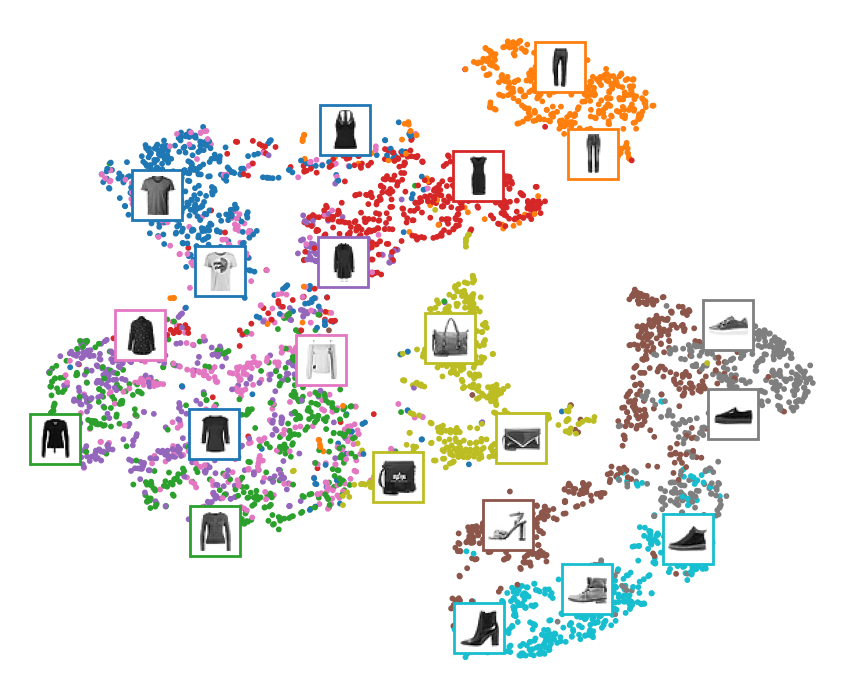

In [15]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

## Tying weights

It is common to tie the weights of the encoder and the decoder, by simply using the transpose of the encoder's weights as the decoder weights. For this, we need to use a custom layer.

In [16]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [17]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3277 - rounded_accuracy: 0.8950 - val_loss: 0.3056 - val_rounded_accuracy: 0.9125
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2981 - rounded_accuracy: 0.9216 - val_loss: 0.2956 - val_rounded_accuracy: 0.9237
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2920 - rounded_accuracy: 0.9273 - val_loss: 0.2925 - val_rounded_accuracy: 0.9242
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2888 - rounded_accuracy: 0.9303 - val_loss: 0.2886 - val_rounded_accuracy: 0.9329
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2865 - rounded_accuracy: 0.9324 - val_loss: 0.2863 - val_rounded_accuracy: 0.9336
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2849 - rounded_accuracy: 0.9340 - val_loss: 0.2855 - val_rounded_accuracy: 0.9359
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 71ms/step


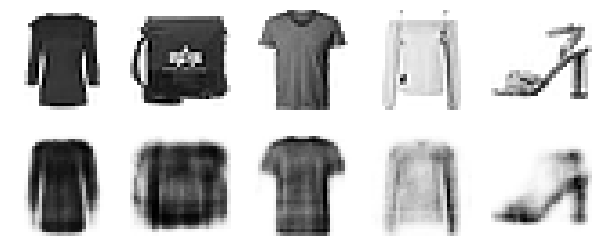

In [18]:
show_reconstructions(tied_ae)
plt.show()

## Training one Autoencoder at a Time

In [19]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                      n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics=metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [20]:
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
X_train_flat = K.batch_flatten(X_train) # equivalent to .reshape(-1, 28 * 28)
X_valid_flat = K.batch_flatten(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat, "binary_crossentropy",
    keras.optimizers.SGD(learning_rate=1.5), output_activation="sigmoid",
    metrics=[rounded_accuracy])
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, "mse", keras.optimizers.SGD(learning_rate=0.05),
    output_activation="selu")

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3441 - rounded_accuracy: 0.8880 - val_loss: 0.3119 - val_rounded_accuracy: 0.9152
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3034 - rounded_accuracy: 0.9209 - val_loss: 0.3002 - val_rounded_accuracy: 0.9250
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2946 - rounded_accuracy: 0.9288 - val_loss: 0.2933 - val_rounded_accuracy: 0.9315
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2890 - rounded_accuracy: 0.9342 - val_loss: 0.2888 - val_rounded_accuracy: 0.9362
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2854 - rounded_accuracy: 0.9377 - val_loss: 0.2858 - val_rounded_accuracy: 0.9391
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2828 - rounded_accuracy: 0.9402 - val_loss: 0.2835 - val_rounded_accuracy: 0.9406
Epoch 7/10
1719/1719 [==================

In [21]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])

1/1 [==============================] - 0s 66ms/step


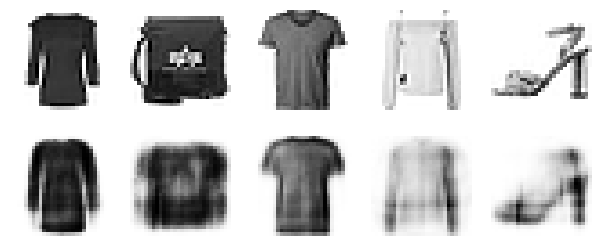

In [22]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

In [23]:
stacked_ae_1_by_1.compile(loss="binary_crossentropy",
                          optimizer=keras.optimizers.SGD(learning_rate=0.1), metrics=[rounded_accuracy])
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=10,
                                validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2865 - rounded_accuracy: 0.9345 - val_loss: 0.2881 - val_rounded_accuracy: 0.9344
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2861 - rounded_accuracy: 0.9349 - val_loss: 0.2878 - val_rounded_accuracy: 0.9347
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2859 - rounded_accuracy: 0.9352 - val_loss: 0.2876 - val_rounded_accuracy: 0.9348
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2857 - rounded_accuracy: 0.9354 - val_loss: 0.2874 - val_rounded_accuracy: 0.9352
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2855 - rounded_accuracy: 0.9356 - val_loss: 0.2873 - val_rounded_accuracy: 0.9354
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2853 - rounded_accuracy: 0.9358 - val_loss: 0.2871 - val_rounded_accuracy: 0.9352
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 72ms/step


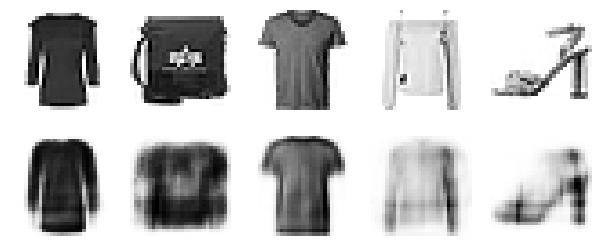

In [24]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

## Using Convolutional Layers Instead of Dense Layers

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [25]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 17s 6ms/step - loss: 0.2992 - rounded_accuracy: 0.9215 - val_loss: 0.2828 - val_rounded_accuracy: 0.9329
Epoch 2/5
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2754 - rounded_accuracy: 0.9418 - val_loss: 0.2762 - val_rounded_accuracy: 0.9436
Epoch 3/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2709 - rounded_accuracy: 0.9464 - val_loss: 0.2712 - val_rounded_accuracy: 0.9481
Epoch 4/5
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2683 - rounded_accuracy: 0.9492 - val_loss: 0.2688 - val_rounded_accuracy: 0.9489
Epoch 5/5
1719/1719 [==============================] - 9s 6ms/step - loss: 0.2665 - rounded_accuracy: 0.9511 - val_loss: 0.2661 - val_rounded_accuracy: 0.9535


In [26]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)        

1/1 [==============================] - 0s 260ms/step


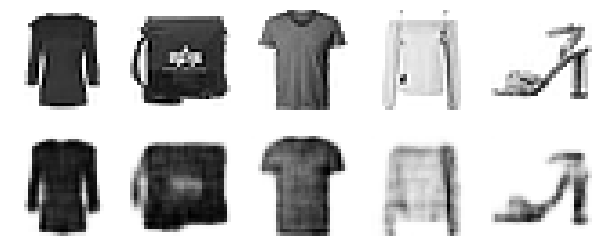

In [27]:
show_reconstructions(conv_ae)
plt.show()

# Recurrent Autoencoders

In [28]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])

In [29]:
history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 24s 11ms/step - loss: 0.5146 - rounded_accuracy: 0.7480 - val_loss: 0.4460 - val_rounded_accuracy: 0.8167
Epoch 2/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.4022 - rounded_accuracy: 0.8411 - val_loss: 0.3772 - val_rounded_accuracy: 0.8594
Epoch 3/10
1719/1719 [==============================] - 18s 10ms/step - loss: 0.3669 - rounded_accuracy: 0.8690 - val_loss: 0.3707 - val_rounded_accuracy: 0.8636
Epoch 4/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.3521 - rounded_accuracy: 0.8808 - val_loss: 0.3493 - val_rounded_accuracy: 0.8862
Epoch 5/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.3418 - rounded_accuracy: 0.8877 - val_loss: 0.3393 - val_rounded_accuracy: 0.8881
Epoch 6/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.3345 - rounded_accuracy: 0.8922 - val_loss: 0.3371 - val_rounded_accuracy: 0.8865
Epoch 7/10
1719/1719 [======

1/1 [==============================] - 1s 912ms/step


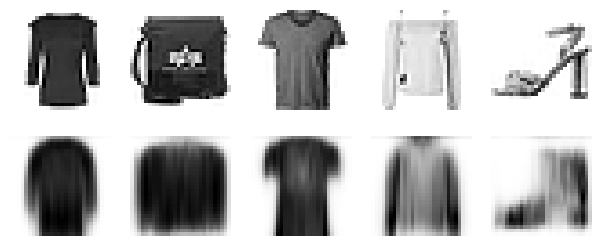

In [30]:
show_reconstructions(recurrent_ae)
plt.show()

# Stacked denoising Autoencoder

Using Gaussian noise:

In [31]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 4ms/step - loss: 0.3486 - rounded_accuracy: 0.8783 - val_loss: 0.3183 - val_rounded_accuracy: 0.9028
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3116 - rounded_accuracy: 0.9101 - val_loss: 0.3069 - val_rounded_accuracy: 0.9169
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3046 - rounded_accuracy: 0.9162 - val_loss: 0.3014 - val_rounded_accuracy: 0.9210
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3007 - rounded_accuracy: 0.9197 - val_loss: 0.2980 - val_rounded_accuracy: 0.9237
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2978 - rounded_accuracy: 0.9222 - val_loss: 0.2955 - val_rounded_accuracy: 0.9257
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2955 - rounded_accuracy: 0.9244 - val_loss: 0.2936 - val_rounded_accuracy: 0.9290
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 70ms/step


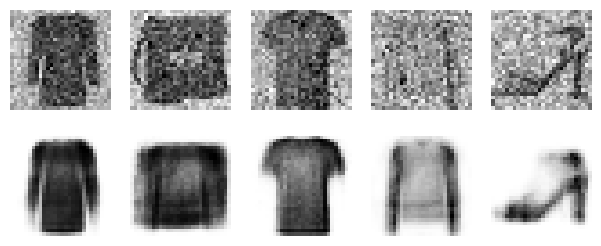

In [32]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

Using dropout:

In [33]:
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3545 - rounded_accuracy: 0.8731 - val_loss: 0.3199 - val_rounded_accuracy: 0.9048
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3183 - rounded_accuracy: 0.9031 - val_loss: 0.3111 - val_rounded_accuracy: 0.9119
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3117 - rounded_accuracy: 0.9085 - val_loss: 0.3056 - val_rounded_accuracy: 0.9167
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3078 - rounded_accuracy: 0.9118 - val_loss: 0.3027 - val_rounded_accuracy: 0.9200
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3051 - rounded_accuracy: 0.9139 - val_loss: 0.2999 - val_rounded_accuracy: 0.9216
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3031 - rounded_accuracy: 0.9155 - val_loss: 0.2988 - val_rounded_accuracy: 0.9204
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 69ms/step
Saving figure dropout_denoising_plot


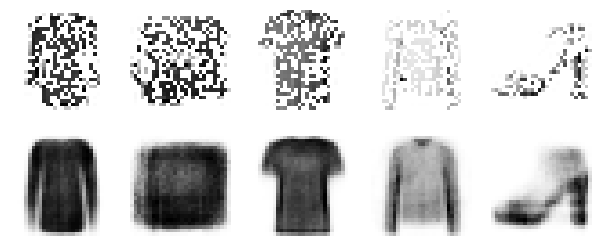

In [34]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))
save_fig("dropout_denoising_plot", tight_layout=False)

# Sparse Autoencoder

Let's build a simple stacked autoencoder, so we can compare it to the sparse autoencoders we will build. This time we will use the sigmoid activation function for the coding layer, to ensure that the coding values range from 0 to 1:

In [35]:
tf.random.set_seed(42)
np.random.seed(42)

simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="sigmoid"),
])
simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.),
                  metrics=[rounded_accuracy])
history = simple_ae.fit(X_train, X_train, epochs=10,
                        validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4422 - rounded_accuracy: 0.7881 - val_loss: 0.3803 - val_rounded_accuracy: 0.8471
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3652 - rounded_accuracy: 0.8637 - val_loss: 0.3593 - val_rounded_accuracy: 0.8748
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3470 - rounded_accuracy: 0.8807 - val_loss: 0.3411 - val_rounded_accuracy: 0.8866
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3332 - rounded_accuracy: 0.8920 - val_loss: 0.3310 - val_rounded_accuracy: 0.8979
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3244 - rounded_accuracy: 0.8988 - val_loss: 0.3230 - val_rounded_accuracy: 0.9015
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3197 - rounded_accuracy: 0.9020 - val_loss: 0.3200 - val_rounded_accuracy: 0.9018
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 65ms/step


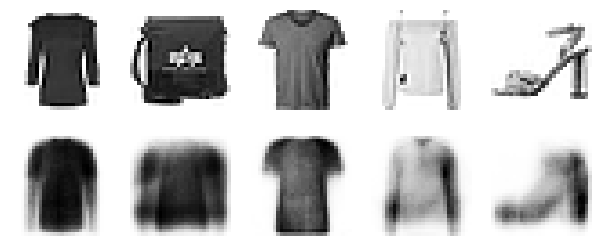

In [36]:
show_reconstructions(simple_ae)
plt.show()

Let's create a couple functions to print nice activation histograms:

In [37]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

In [38]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

Let's use these functions to plot histograms of the activations of the encoding layer. The histogram on the left shows the distribution of all the activations. You can see that values close to 0 or 1 are more frequent overall, which is consistent with the saturating nature of the sigmoid function. The histogram on the right shows the distribution of mean neuron activations: you can see that most neurons have a mean activation close to 0.5. Both histograms tell us that each neuron tends to either fire close to 0 or 1, with about 50% probability each. However, some neurons fire almost all the time (right side of the right histogram).

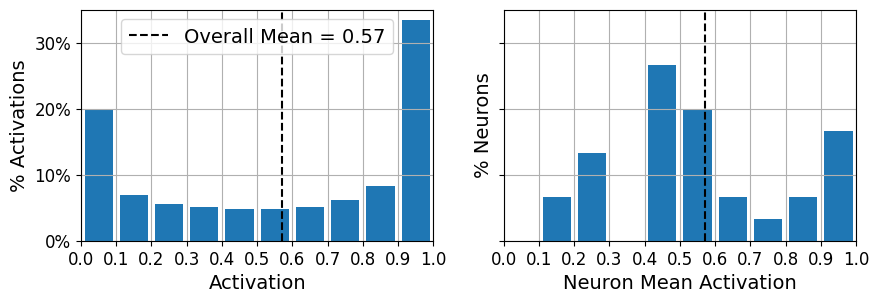

In [39]:
plot_activations_histogram(simple_encoder, height=0.35)
plt.show()

Now let's add $\ell_1$ regularization to the coding layer:

In [40]:
tf.random.set_seed(42)
np.random.seed(42)

sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3)  # Alternatively, you could add
                                                  # activity_regularizer=keras.regularizers.l1(1e-3)
                                                  # to the previous layer.
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 12s 5ms/step - loss: 0.4322 - rounded_accuracy: 0.8152 - val_loss: 0.3807 - val_rounded_accuracy: 0.8572
Epoch 2/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3691 - rounded_accuracy: 0.8690 - val_loss: 0.3639 - val_rounded_accuracy: 0.8739
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3544 - rounded_accuracy: 0.8794 - val_loss: 0.3500 - val_rounded_accuracy: 0.8839
Epoch 4/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3431 - rounded_accuracy: 0.8877 - val_loss: 0.3419 - val_rounded_accuracy: 0.8916
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3366 - rounded_accuracy: 0.8922 - val_loss: 0.3358 - val_rounded_accuracy: 0.8947
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3308 - rounded_accuracy: 0.8975 - val_loss: 0.3297 - val_rounded_accuracy: 0.8997
Epoch 7/10
1719/1719 [=================

1/1 [==============================] - 0s 75ms/step


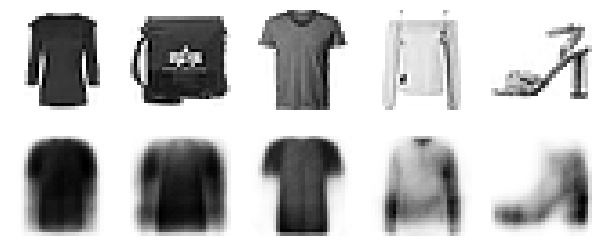

In [41]:
show_reconstructions(sparse_l1_ae)

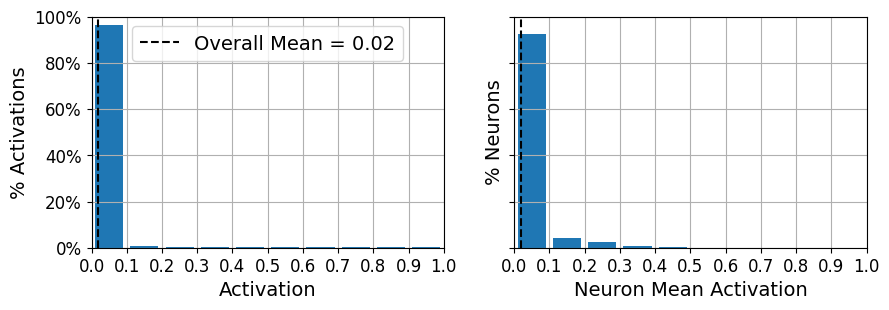

In [42]:
plot_activations_histogram(sparse_l1_encoder, height=1.)
plt.show()

Let's use the KL Divergence loss instead to ensure sparsity, and target 10% sparsity rather than 0%:

Saving figure sparsity_loss_plot


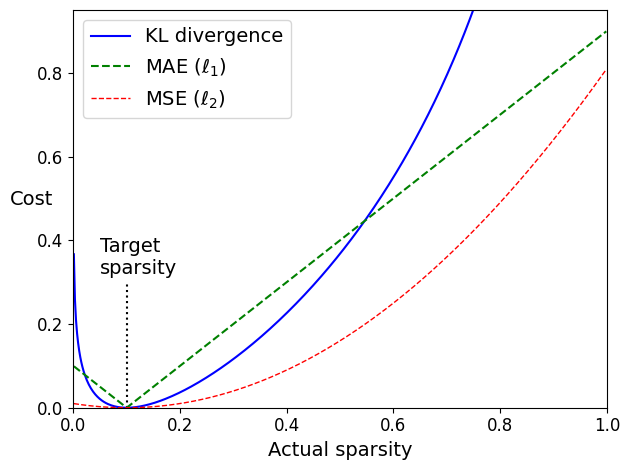

In [43]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
save_fig("sparsity_loss_plot")

In [44]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

In [45]:
tf.random.set_seed(42)
np.random.seed(42)

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
              metrics=[rounded_accuracy])
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4165 - rounded_accuracy: 0.8108 - val_loss: 0.3723 - val_rounded_accuracy: 0.8565
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3525 - rounded_accuracy: 0.8770 - val_loss: 0.3421 - val_rounded_accuracy: 0.8876
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3311 - rounded_accuracy: 0.8951 - val_loss: 0.3262 - val_rounded_accuracy: 0.9002
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3205 - rounded_accuracy: 0.9036 - val_loss: 0.3200 - val_rounded_accuracy: 0.9054
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3157 - rounded_accuracy: 0.9075 - val_loss: 0.3160 - val_rounded_accuracy: 0.9086
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3124 - rounded_accuracy: 0.9103 - val_loss: 0.3130 - val_rounded_accuracy: 0.9108
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 91ms/step


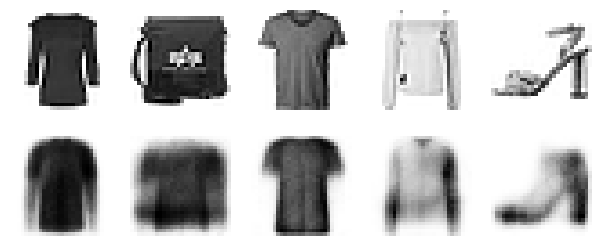

In [46]:
show_reconstructions(sparse_kl_ae)

Saving figure sparse_autoencoder_plot


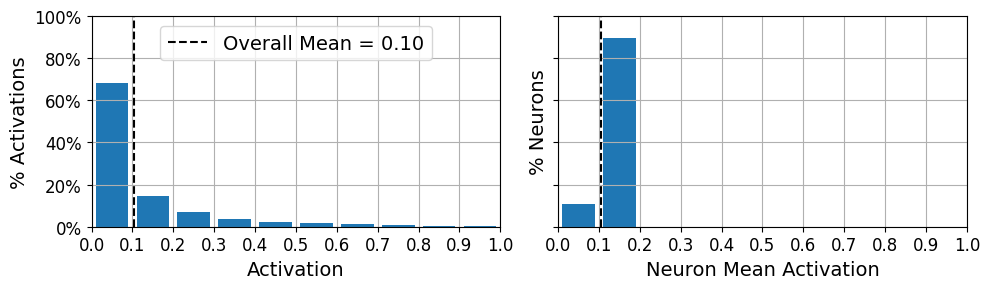

In [47]:
plot_activations_histogram(sparse_kl_encoder)
save_fig("sparse_autoencoder_plot")
plt.show()

# Variational Autoencoder

In [48]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [49]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 6s 8ms/step - loss: 0.4115 - rounded_accuracy: 0.8390 - val_loss: 0.3711 - val_rounded_accuracy: 0.8828
Epoch 2/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3569 - rounded_accuracy: 0.8877 - val_loss: 0.3505 - val_rounded_accuracy: 0.8942
Epoch 3/25
430/430 [==============================] - 2s 6ms/step - loss: 0.3440 - rounded_accuracy: 0.8976 - val_loss: 0.3435 - val_rounded_accuracy: 0.8947
Epoch 4/25
430/430 [==============================] - 2s 6ms/step - loss: 0.3371 - rounded_accuracy: 0.9024 - val_loss: 0.3360 - val_rounded_accuracy: 0.9024
Epoch 5/25
430/430 [==============================] - 3s 6ms/step - loss: 0.3325 - rounded_accuracy: 0.9059 - val_loss: 0.3348 - val_rounded_accuracy: 0.9073
Epoch 6/25
430/430 [==============================] - 3s 6ms/step - loss: 0.3293 - rounded_accuracy: 0.9080 - val_loss: 0.3311 - val_rounded_accuracy: 0.9038
Epoch 7/25
430/430 [==============================] 

1/1 [==============================] - 0s 119ms/step


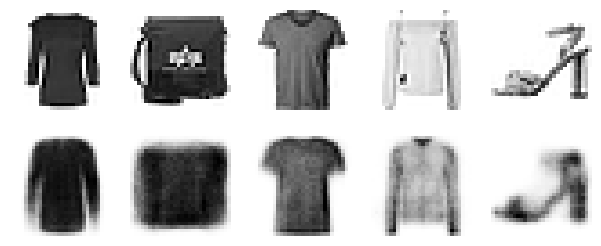

In [50]:
show_reconstructions(variational_ae)
plt.show()

## Generate Fashion Images

In [51]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

Let's generate a few random codings, decode them and plot the resulting images:

Saving figure vae_generated_images_plot


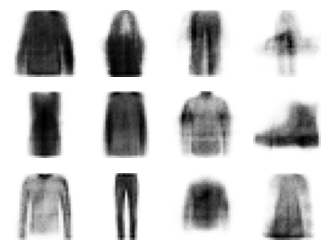

In [52]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
save_fig("vae_generated_images_plot", tight_layout=False)

Now let's perform semantic interpolation between these images:

Saving figure semantic_interpolation_plot


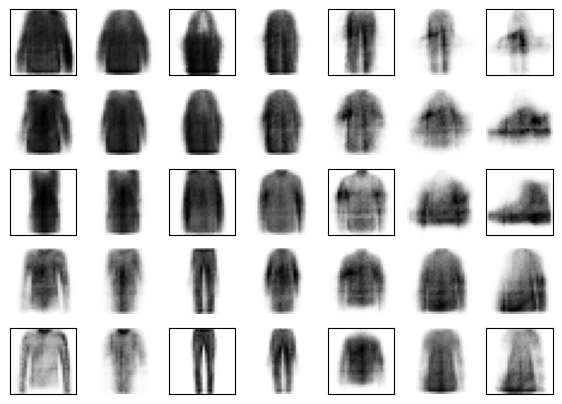

In [53]:
tf.random.set_seed(42)
np.random.seed(42)

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")
save_fig("semantic_interpolation_plot", tight_layout=False)

# Generative Adversarial Networks

In [54]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [55]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [56]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [57]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)                     # not shown
        plt.show()                                                    # not shown

Epoch 1/1


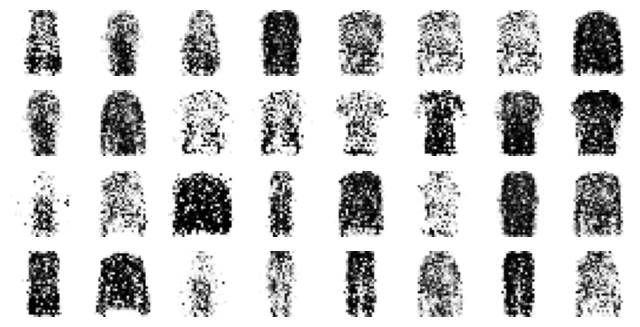

In [58]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

Saving figure gan_generated_images_plot


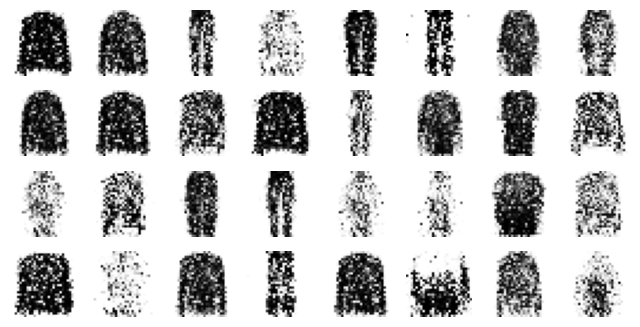

In [59]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("gan_generated_images_plot", tight_layout=False)

Epoch 1/50


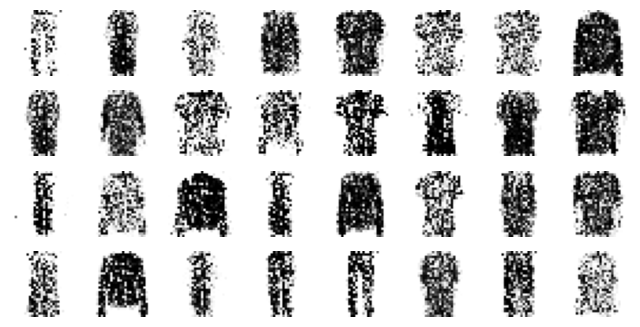

Epoch 2/50


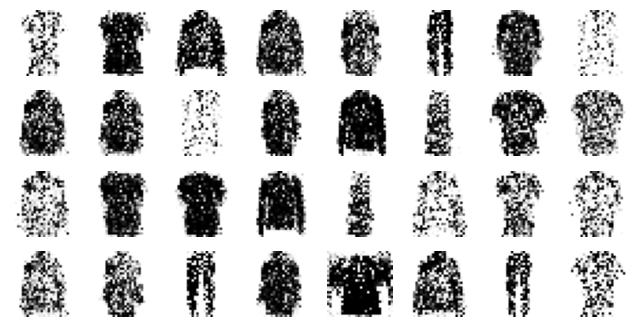

Epoch 3/50


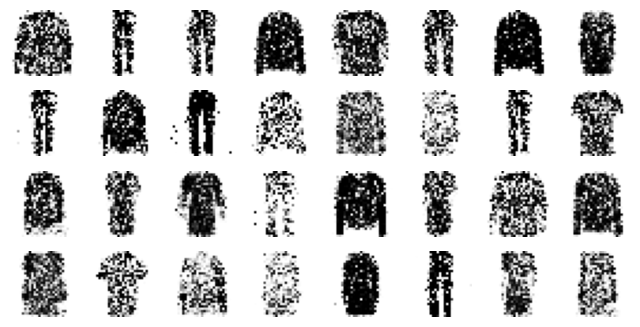

Epoch 4/50


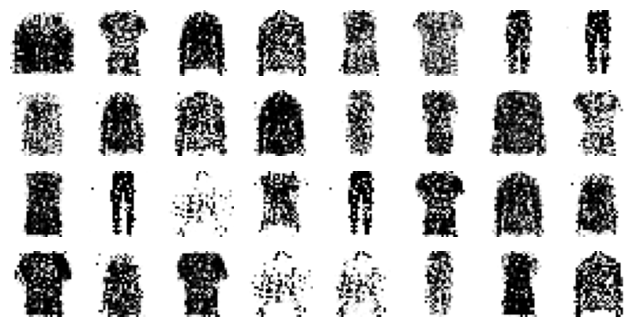

Epoch 5/50


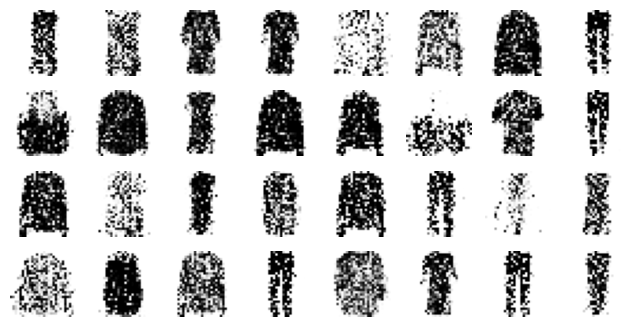

Epoch 6/50


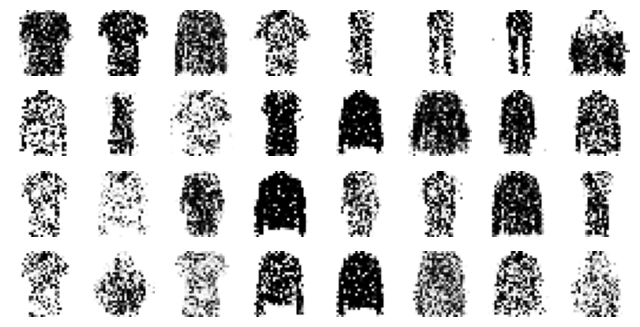

Epoch 7/50


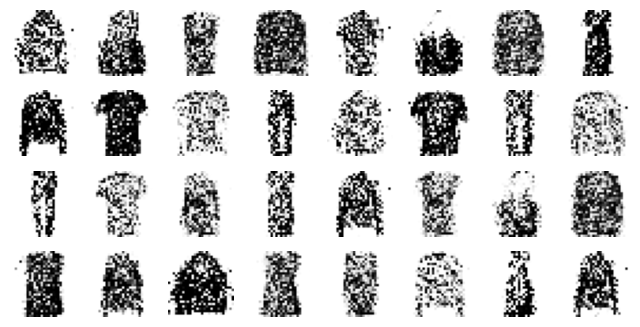

Epoch 8/50


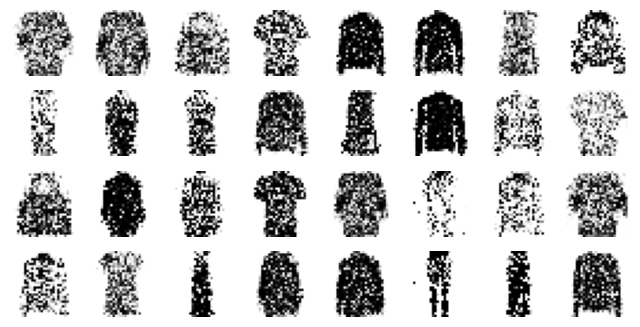

Epoch 9/50


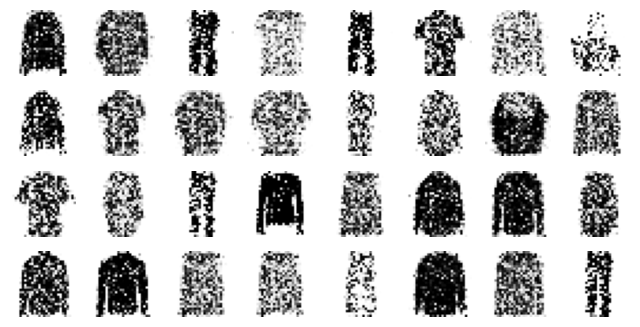

Epoch 10/50


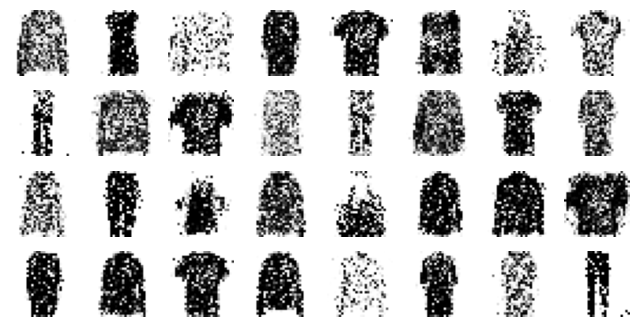

Epoch 11/50


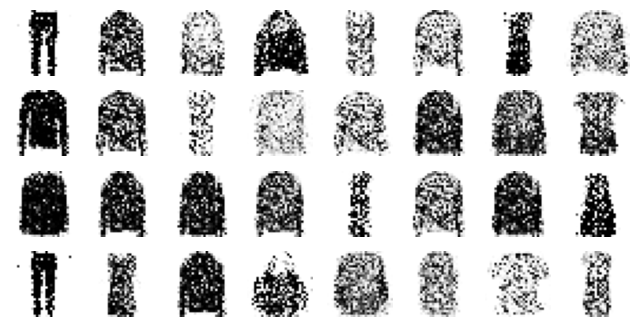

Epoch 12/50


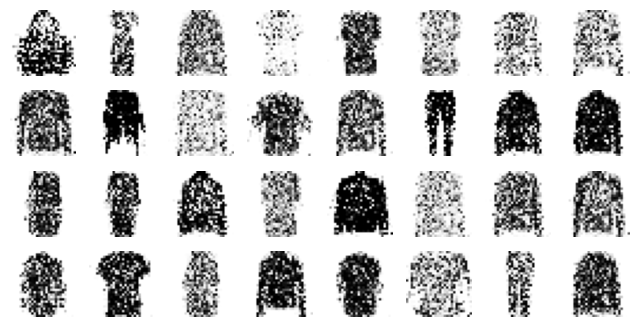

Epoch 13/50


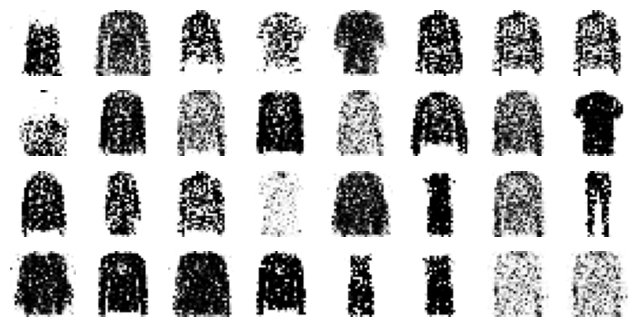

Epoch 14/50


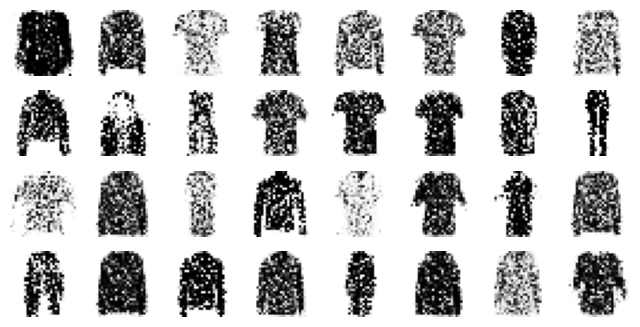

Epoch 15/50


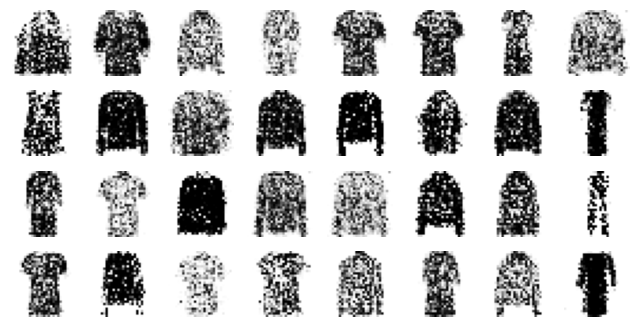

Epoch 16/50


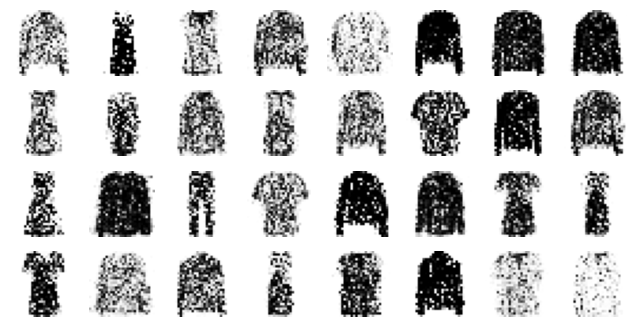

Epoch 17/50


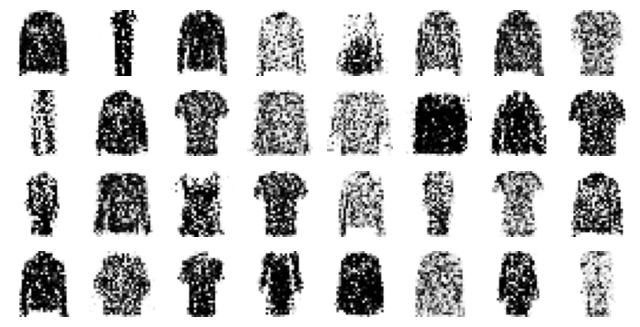

Epoch 18/50


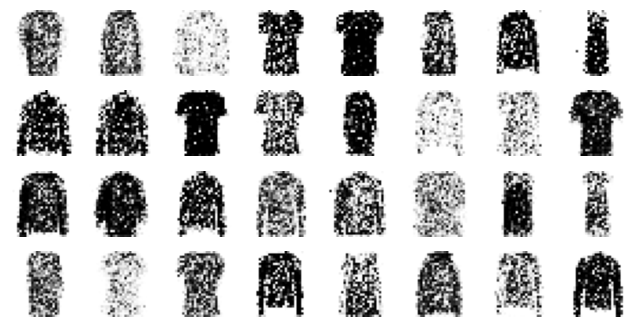

Epoch 19/50


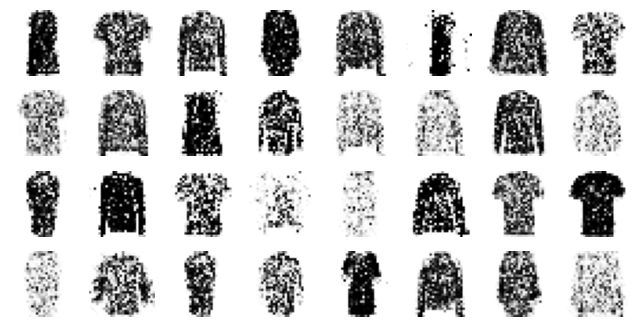

Epoch 20/50


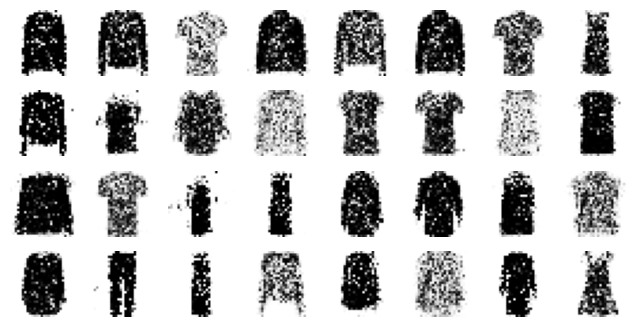

Epoch 21/50


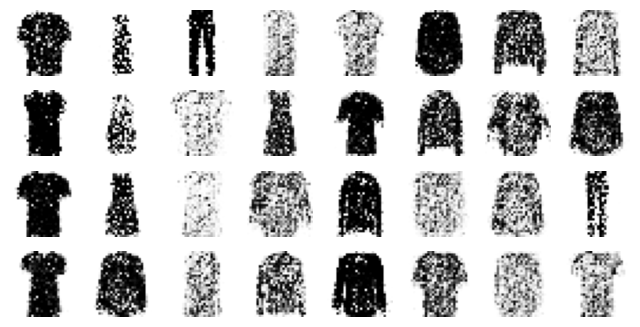

Epoch 22/50


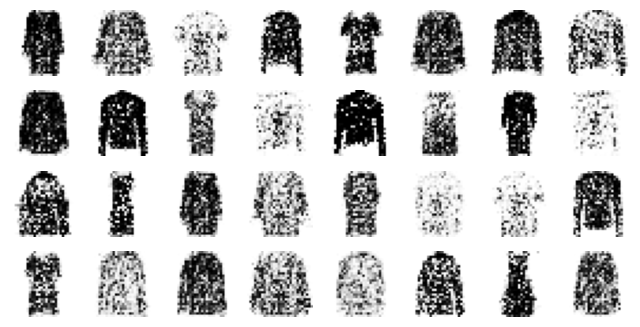

Epoch 23/50


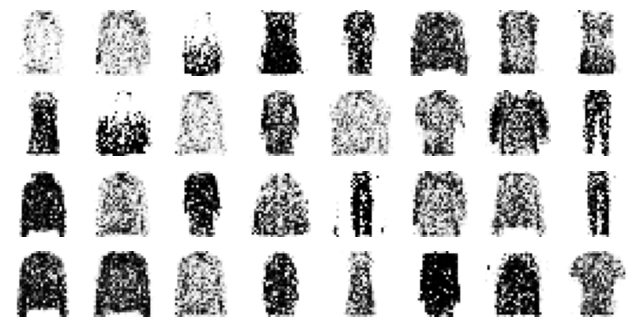

Epoch 24/50


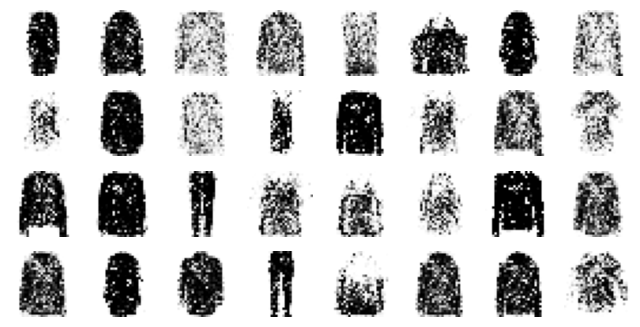

Epoch 25/50


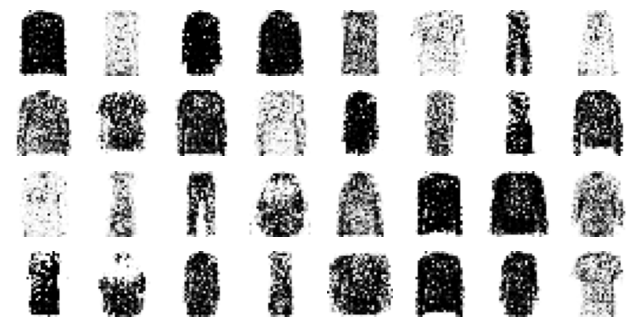

Epoch 26/50


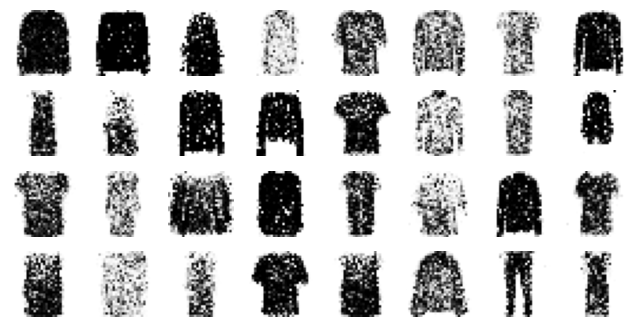

Epoch 27/50


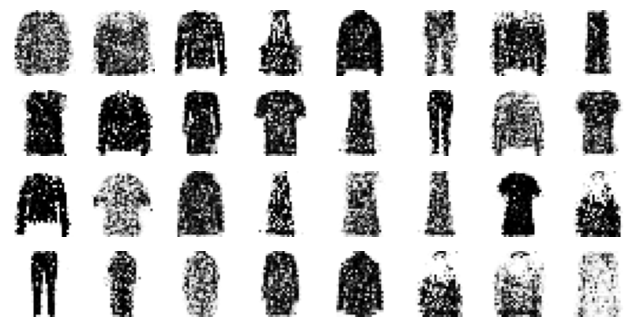

Epoch 28/50


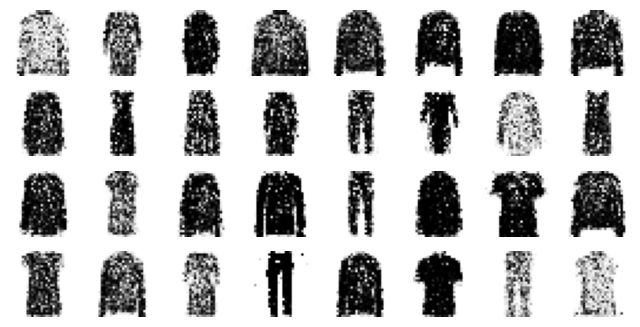

Epoch 29/50


In [ ]:
train_gan(gan, dataset, batch_size, codings_size)

# Deep Convolutional GAN

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [ ]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
train_gan(gan, dataset, batch_size, codings_size)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("dcgan_generated_images_plot", tight_layout=False)

# Extra Material

## Hashing Using a Binary Autoencoder

Let's load the Fashion MNIST dataset again:

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

Let's train an autoencoder where the encoder has a 16-neuron output layer, using the sigmoid activation function, and heavy Gaussian noise just before it. During training, the noise layer will encourage the previous layer to learn to output large values, since small values will just be crushed by the noise. In turn, this means that the output layer will output values close to 0 or 1, thanks to the sigmoid activation function. Once we round the output values to 0s and 1s, we get a 16-bit "semantic" hash. If everything works well, images that look alike will have the same hash. This can be very useful for search engines: for example, if we store each image on a server identified by the image's semantic hash, then all similar images will end up on the same server. Users of the search engine can then provide an image to search for, and the search engine will compute the image's hash using the encoder, and quickly return all the images on the server identified by that hash.

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

hashing_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.GaussianNoise(15.),
    keras.layers.Dense(16, activation="sigmoid"),
])
hashing_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[16]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
hashing_ae = keras.models.Sequential([hashing_encoder, hashing_decoder])
hashing_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Nadam(),
                   metrics=[rounded_accuracy])
history = hashing_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4462 - rounded_accuracy: 0.7827 - val_loss: 0.3881 - val_rounded_accuracy: 0.8251
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3712 - rounded_accuracy: 0.8455 - val_loss: 0.3706 - val_rounded_accuracy: 0.8402
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3587 - rounded_accuracy: 0.8567 - val_loss: 0.3619 - val_rounded_accuracy: 0.8514
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3532 - rounded_accuracy: 0.8631 - val_loss: 0.3559 - val_rounded_accuracy: 0.8614
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3486 - rounded_accuracy: 0.8680 - val_loss: 0.3472 - val_rounded_accuracy: 0.8689
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3467 - rounded_accuracy: 0.8704 - val_loss: 0.3448 - val_rounded_accuracy: 0.8747
Epoch 7/10
1719/1719 [==================

The autoencoder compresses the information so much (down to 16 bits!) that it's quite lossy, but that's okay, we're using it to produce semantic hashes, not to perfectly reconstruct the images:

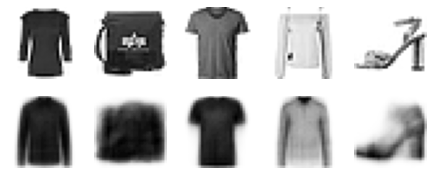

In [ ]:
show_reconstructions(hashing_ae)
plt.show()

Notice that the outputs are indeed very close to 0 or 1 (left graph):

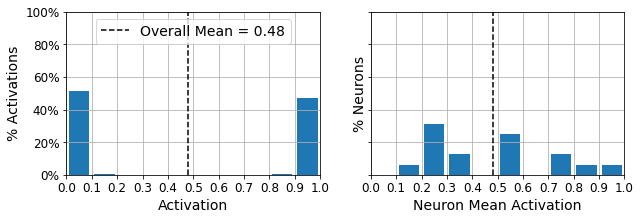

In [ ]:
plot_activations_histogram(hashing_encoder)
plt.show()

Now let's see what the hashes look like for the first few images in the validation set:

In [ ]:
hashes = np.round(hashing_encoder.predict(X_valid)).astype(np.int32)
hashes *= np.array([[2**bit for bit in range(16)]])
hashes = hashes.sum(axis=1)
for h in hashes[:5]:
    print("{:016b}".format(h))
print("...")

0000100101011011
0000100100110011
0100100100011011
0001100111001010
0001010100110000
...


Now let's find the most common image hashes in the validation set, and display a few images for each hash. In the following image, all the images on a given row have the same hash:

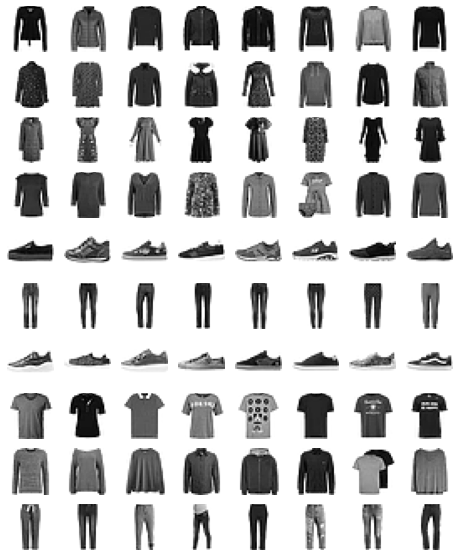

In [ ]:
from collections import Counter

n_hashes = 10
n_images = 8

top_hashes = Counter(hashes).most_common(n_hashes)

plt.figure(figsize=(n_images, n_hashes))
for hash_index, (image_hash, hash_count) in enumerate(top_hashes):
    indices = (hashes == image_hash)
    for index, image in enumerate(X_valid[indices][:n_images]):
        plt.subplot(n_hashes, n_images, hash_index * n_images + index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

# Exercise Solutions

## 1. to 8.

See Appendix A.

## 9.
_Exercise: Try using a denoising autoencoder to pretrain an image classifier. You can use MNIST (the simplest option), or a more complex image dataset such as [CIFAR10](https://homl.info/122) if you want a bigger challenge. Regardless of the dataset you're using, follow these steps:_
* Split the dataset into a training set and a test set. Train a deep denoising autoencoder on the full training set.
* Check that the images are fairly well reconstructed. Visualize the images that most activate each neuron in the coding layer.
* Build a classification DNN, reusing the lower layers of the autoencoder. Train it using only 500 images from the training set. Does it perform better with or without pretraining?

In [ ]:
[X_train, y_train], [X_test, y_test] = keras.datasets.cifar10.load_data()
X_train = X_train / 255
X_test = X_test / 255

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.GaussianNoise(0.1, input_shape=[32, 32, 3]),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"),
])

In [ ]:
denoising_encoder.summary()

Model: "sequential_105"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_36 (GaussianN (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_70 (Dense)             (None, 512)               4194816   
Total params: 4,195,712
Trainable params: 4,195,712
Non-trainable params: 0
_________________________________________________________________


In [ ]:
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(16 * 16 * 32, activation="relu", input_shape=[512]),
    keras.layers.Reshape([16, 16, 32]),
    keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=2,
                                 padding="same", activation="sigmoid")
])

In [ ]:
denoising_decoder.summary()

Model: "sequential_106"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 8192)              4202496   
_________________________________________________________________
reshape_22 (Reshape)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_transpose_62 (Conv2DT (None, 32, 32, 3)         867       
Total params: 4,203,363
Trainable params: 4,203,363
Non-trainable params: 0
_________________________________________________________________


In [ ]:
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Nadam(),
                     metrics=["mse"])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_test, X_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 160s 3ms/sample - loss: 0.5936 - mse: 0.0187 - val_loss: 0.5849 - val_mse: 0.0143
Epoch 2/10
50000/50000 [==============================] - 169s 3ms/sample - loss: 0.5727 - mse: 0.0100 - val_loss: 0.5783 - val_mse: 0.0117
Epoch 3/10
50000/50000 [==============================] - 183s 4ms/sample - loss: 0.5676 - mse: 0.0080 - val_loss: 0.5715 - val_mse: 0.0090
Epoch 4/10
50000/50000 [==============================] - 182s 4ms/sample - loss: 0.5653 - mse: 0.0071 - val_loss: 0.5695 - val_mse: 0.0083
Epoch 5/10
50000/50000 [==============================] - 185s 4ms/sample - loss: 0.5639 - mse: 0.0066 - val_loss: 0.5687 - val_mse: 0.0079
Epoch 6/10
50000/50000 [==============================] - 158s 3ms/sample - loss: 0.5629 - mse: 0.0062 - val_loss: 0.5669 - val_mse: 0.0072
Epoch 7/10
50000/50000 [==============================] - 157s 3ms/sample - loss: 0.5622 - mse: 0.0060 - val_l

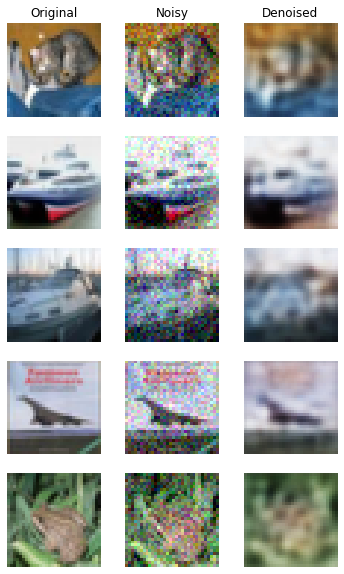

In [ ]:
n_images = 5
new_images = X_test[:n_images]
new_images_noisy = new_images + np.random.randn(n_images, 32, 32, 3) * 0.1
new_images_denoised = denoising_ae.predict(new_images_noisy)

plt.figure(figsize=(6, n_images * 2))
for index in range(n_images):
    plt.subplot(n_images, 3, index * 3 + 1)
    plt.imshow(new_images[index])
    plt.axis('off')
    if index == 0:
        plt.title("Original")
    plt.subplot(n_images, 3, index * 3 + 2)
    plt.imshow(np.clip(new_images_noisy[index], 0., 1.))
    plt.axis('off')
    if index == 0:
        plt.title("Noisy")
    plt.subplot(n_images, 3, index * 3 + 3)
    plt.imshow(new_images_denoised[index])
    plt.axis('off')
    if index == 0:
        plt.title("Denoised")
plt.show()

## 10.
_Exercise: Train a variational autoencoder on the image dataset of your choice, and use it to generate images. Alternatively, you can try to find an unlabeled dataset that you are interested in and see if you can generate new samples._


## 11.
_Exercise: Train a DCGAN to tackle the image dataset of your choice, and use it to generate images. Add experience replay and see if this helps. Turn it into a conditional GAN where you can control the generated class._
